<a href="https://colab.research.google.com/github/sean-otoole/HODD/blob/main/PDTx_pipeline/PDTx_04_Perturbation_DA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#fixes a compatibility issue with the PrecollatorForGeneAndCellClassification class

!pip install --upgrade transformers==4.41
!pip install peft==0.10.0

In [ ]:
#first mount the drive

from google.colab import drive
import os

# Mount Google Drive to access files
drive.mount('/content/drive')

# Change the working directory to the project folder in Google Drive
os.chdir("/content/drive/MyDrive/HODD/")

# Install Git Large File Storage (LFS) for handling large files in Git repositories
# !git lfs install

#Clone the Geneformer repository (commented out to avoid repeated cloning)
# !git clone https://huggingface.co/ctheodoris/Geneformer

# Navigate to the Geneformer directory
%cd Geneformer

# Install Geneformer package locally
# I found that installing Genformer first helped with a lot of the version conflict issues
!pip install .

# Install required libraries without outputting installation logs
!pip install anndata scanpy tdigest datasets

# Import necessary modules and libraries
import numpy
import transformers
import sklearn
import pickle
import sklearn

In [ ]:
from geneformer import InSilicoPerturber
from geneformer import InSilicoPerturberStats
from geneformer import EmbExtractor

In [ ]:
cell_states_to_model={"state_key": "disease_state",
                      "start_state": "Parkinson_disease",
                      "goal_state": "normal"}

In [ ]:
embex = EmbExtractor(model_type="CellClassifier", # if using previously fine-tuned cell classifier model
                     num_classes=2,
                     max_ncells=2000,
                     emb_layer=0,
                     summary_stat="exact_mean",
                     forward_batch_size=100,
                     nproc=4)

In [ ]:
fine_tuned_model = '/content/drive/MyDrive/HODD/models/geneformer_finetuned_v1/250414_geneformer_cellClassifier_park_classifier/ksplit1/'
output_dir = '/content/drive/MyDrive/HODD/perturbation_analysis_overexpress_output'
current_prefix = 'park_overexpress'
input_data =  '/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_subset_test_tokenized.dataset/'   #would like to make this all of the data

state_embs_dict = embex.get_state_embs(cell_states_to_model,
                                       fine_tuned_model,
                                       input_data,
                                       output_dir,
                                       current_prefix)

In [ ]:
isp = InSilicoPerturber(perturb_type="overexpress",
                        perturb_rank_shift=None,
                        genes_to_perturb="all",
                        # genes_to_perturb=genes_to_perturb_ensembl,
                        combos=0,
                        anchor_gene=None,
                        model_type="CellClassifier", # if using previously fine-tuned cell classifier model
                        num_classes=2,
                        emb_mode="cls",   #should be cell - I think, will need to check
                        cell_emb_style="mean_pool",
                        cell_states_to_model=cell_states_to_model,
                        state_embs_dict=state_embs_dict,
                        max_ncells=400,
                        emb_layer=0,
                        forward_batch_size=200,
                        nproc=1)

In [ ]:
# outputs intermediate files from in silico perturbation
isp.perturb_data(fine_tuned_model,
                 input_data,
                 output_dir,
                 "parkinson_overexpress_stats")

In [ ]:
ispstats = InSilicoPerturberStats(mode="goal_state_shift",
                                  genes_perturbed="all",
                                  # genes_perturbed = genes_to_perturb_ensembl,
                                  combos=0,
                                  anchor_gene=None,
                                  cell_states_to_model=cell_states_to_model)

In [ ]:
# extracts data from intermediate files and processes stats to output in final .csv
ispstats.get_stats(output_dir, # this should be the directory
                   None,
                   output_dir,
                   "parkinson_overexpress_stats")

In [1]:
from google.colab import drive
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Mount Google Drive to access files
drive.mount('/content/drive')

os.chdir("/content/drive/MyDrive/HODD/figures/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!apt-get update
!apt-get install -y texlive-latex-base texlive-fonts-recommended texlive-fonts-extra texlive-latex-extra cm-super dvipng

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

import matplotlib as mpl
plt.rcParams['text.usetex'] = True  # Enable LaTeX rendering for text

def plot_log_scaled_pvalues(df, x_col='Shift_to_goal_end', y_col='Goal_end_FDR',
                             gene_label_col='Gene_name', top_n=10,
                             title="Log-Scaled P-values", point_color='black', filename=None):
    """
    Plots a scatter plot with a log-scaled, inverted y-axis, labels top_n points,
    and adds a vertical dashed line at x=0 with further apart dashes.

    Parameters:
        df (pd.DataFrame): The input data.
        x_col (str): Column name for x-axis values.
        y_col (str): Column name for y-axis values (FDR or p-values).
        gene_label_col (str): Column name with gene names to label.
        top_n (int): Number of top hits (lowest y_col values) to label.
        title (str): Plot title.
        point_color (str): Color of the scatter points.
    """
    # Set Seaborn theme (grid off)
    #sns.set(style="white", context="talk")  # Removed 'whitegrid' to disable grid
    sns.set(style="ticks", context="talk")  # 'ticks' keeps both gridlines and tick marks visible


    # Create the scatter plot
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.scatterplot(data=df, y=y_col, x=x_col, s=50, color=point_color, edgecolor='black', ax=ax)

    # Apply log scale and invert y-axis
    ax.set_yscale('log')
    ax.invert_yaxis()

    # Remove gridlines explicitly (just in case)
    ax.grid(False)

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add vertical dashed line at x = 0 with further apart dashes
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1,
               dashes=(10, 5))  # Adjust (10, 5) for larger spacing between dashes

    ax.set_xticks([-0.15, 0, 0.15])

    # Set y-ticks at 0 and 10^-110
    log_ticks = np.logspace(-110, 0, num=3)  # Generate ticks from 10^-110 to 10^0
    log_ticks = np.append([1e-110], log_ticks)  # Add 10^-110 as the first tick
    plt.yticks(log_ticks)  # Set ticks on the y-axis
    ax.set_yticks(log_ticks)  # Use ax.set_yticks() instead of plt.yticks()

    # Label top_n genes with lowest FDR values
    top_genes = df.nsmallest(top_n, y_col)

    # Plot the top N points in red
    sns.scatterplot(data=top_genes, y=y_col, x=x_col, s=50, color='red', edgecolor='red', ax=ax)

    # Set consistent font size
    label_fontsize = 12

    # Label top N genes with their names in black
    for _, row in top_genes.iterrows():
        ax.text(row[x_col], row[y_col], row[gene_label_col],
                fontsize=label_fontsize, ha='right', va='bottom', color='black')

    ax.set_xlim(-0.16,0.16)
    ax.set_ylim(0, 1e-120)

    # Apply consistent font size to all axis labels and ticks
    ax.set_title(title, fontsize=label_fontsize)
    ax.set_xlabel("Cos sim shift towards healthy state", fontsize=label_fontsize)
    ax.set_ylabel("-log10(pVal FDR adjusted)", fontsize=label_fontsize)
    ax.tick_params(labelsize=label_fontsize)

    # Tidy layout and show
    plt.tight_layout()

    if filename:
      plt.savefig(f"{filename}.svg", format="svg")  # Save as svg

    plt.show()


In [7]:
overexpression_stats_path = '/content/drive/MyDrive/HODD/perturbation_analysis_overexpress_output/parkinson_overexpress_stats.csv'
deletion_stats_path = '/content/drive/MyDrive/HODD/perturbation_analysis_delete_output/parkinson_delete_stats.csv'

df_overexpress = pd.read_csv(overexpression_stats_path)
df_delete = pd.read_csv(deletion_stats_path)

# Define function for rounding to 2 significant digits
def round_or_format(x, sig=2, as_string=False):
    if pd.isnull(x):
        return x
    formatted_value = f"{x:.{sig}g}"
    return formatted_value if as_string else float(formatted_value)

<ipython-input-8-3d7ccbbeb5a5>:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.iloc[:, -2:] = df.iloc[:, -2:].applymap(round_or_format)


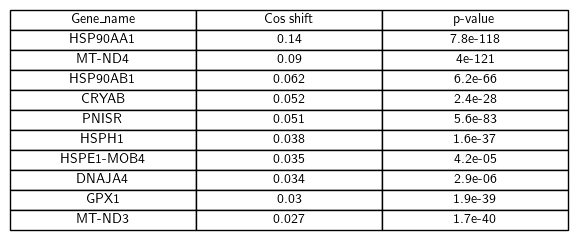

In [8]:
df_delete = df_delete[df_delete["Goal_end_FDR"] < 0.05]

df = df_delete.iloc[0:10,[2,4,5]]
df = df.rename(columns={
    'Shift_to_goal_end': 'Cos shift',
    'Goal_end_vs_random_pval': 'p-value'
})

# Apply this to the last two columns, deciding if you want strings or floats
df.iloc[:, -2:] = df.iloc[:, -2:].applymap(round_or_format)

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 2))  # Adjust size as needed
ax.axis('off')  # Hide axes

# Create table
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

# Beautify
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# Save as PDF or SVG
plt.savefig("delete_table.svg", bbox_inches='tight')

<ipython-input-9-170708c4fee1>:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.iloc[:, -2:] = df.iloc[:, -2:].applymap(round_or_format)


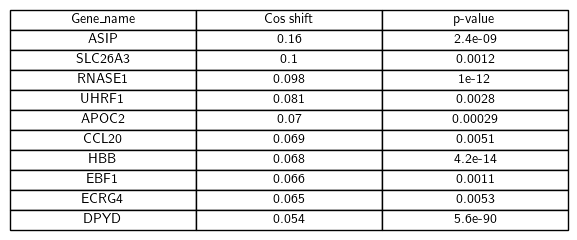

In [9]:
df_overexpress = df_overexpress[df_overexpress["Goal_end_FDR"] < 0.05]
df_overexpress.iloc[0:10]

df = df_overexpress.iloc[0:10,[2,4,5]]
df = df.rename(columns={
    'Shift_to_goal_end': 'Cos shift',
    'Goal_end_vs_random_pval': 'p-value'
})

# Apply this to the last two columns, deciding if you want strings or floats
df.iloc[:, -2:] = df.iloc[:, -2:].applymap(round_or_format)

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 2))  # Adjust size as needed
ax.axis('off')  # Hide axes

# Create table
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

# Beautify
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# Save as PDF or SVG
plt.savefig("overexpress_table.svg", bbox_inches='tight')

<ipython-input-6-406a7bc3241b>:72: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 1e-120)


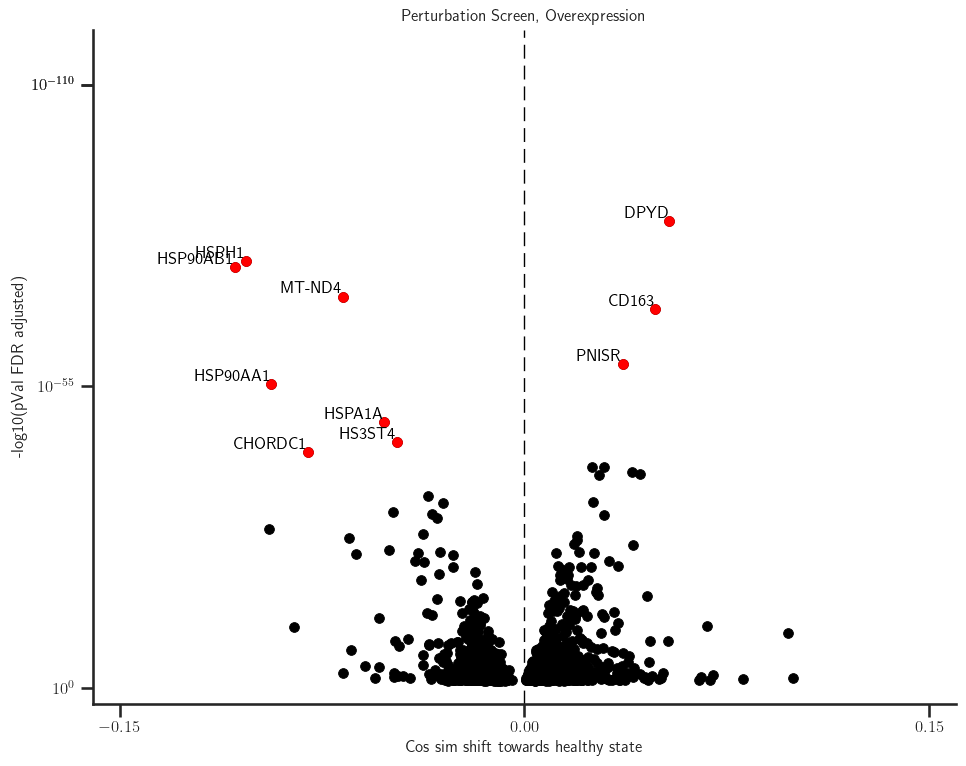

In [10]:
plot_log_scaled_pvalues(df_overexpress, title = 'Perturbation Screen, Overexpression', filename = 'overexpression_scatter')

<ipython-input-6-406a7bc3241b>:72: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 1e-120)


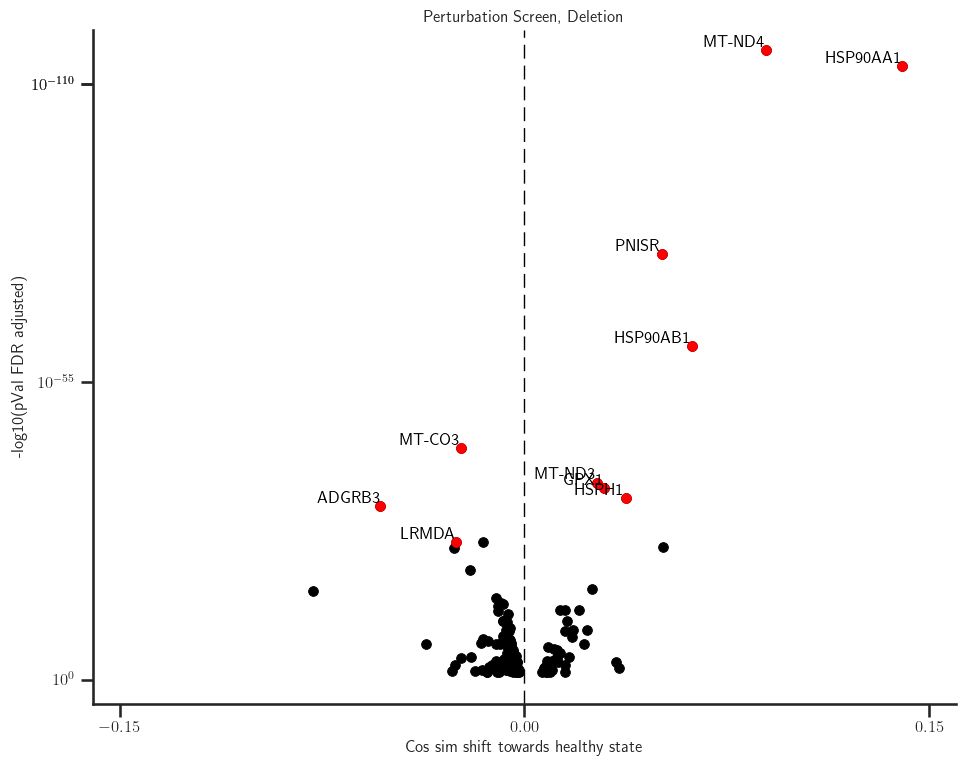

In [11]:
plot_log_scaled_pvalues(df_delete, title = 'Perturbation Screen, Deletion', filename='deletion_scatter')

In [12]:
!pip install gseapy pandas

In [13]:
# human_libs = gp.get_library_name(organism='human')
# human_libs

In [14]:
import gseapy as gp
import numpy as np
import matplotlib.pyplot as plt
import re

def plot_go_enrichment(genes_of_interest, filename=None):
    """
    Perform GO enrichment analysis and plot the enriched biological processes.

    Parameters:
        genes_of_interest (list): List of gene names for enrichment analysis.

    Returns:
        None: Displays the plot.
    """
    # Perform GO enrichment analysis
    enr = gp.enrichr(gene_list=genes_of_interest,
                    gene_sets='GO_Biological_Process_2025',  # You can use different ontologies like GO_Molecular_Function_2018
                    organism='Human',  # 'Human' is the default
                    cutoff=0.05)  # Adjust the p-value cutoff for significance

    # Get the top GO terms sorted by p-value
    top_terms = enr.results[['Term', 'P-value', 'Genes', 'Adjusted P-value']].sort_values(by='P-value').head(10)
    # Remove everything within and including parentheses for each term
    top_terms['Term'] = top_terms['Term'].apply(lambda x: re.sub(r'\(.*\)', '', x))

    # Plot the GO enrichment results
    plt.figure(figsize=(10, 8))
    plt.barh(top_terms['Term'], -np.log10(top_terms['P-value']), color='black')
    plt.xlabel('-log10(P-value)')
    plt.title('Top 10 Enriched GO Biological Processes')
    plt.gca().invert_yaxis()  # Invert to show the most significant terms on top

    # plt.tight_layout()

    if filename:
      plt.savefig(f"{filename}.svg", format="svg")  # Save as svg

    plt.show()

In [15]:
genes_overexpress = df_overexpress[df_overexpress['Shift_to_goal_end']>0]['Gene_name']

genes_delete = df_delete[df_delete['Shift_to_goal_end']>0]['Gene_name']

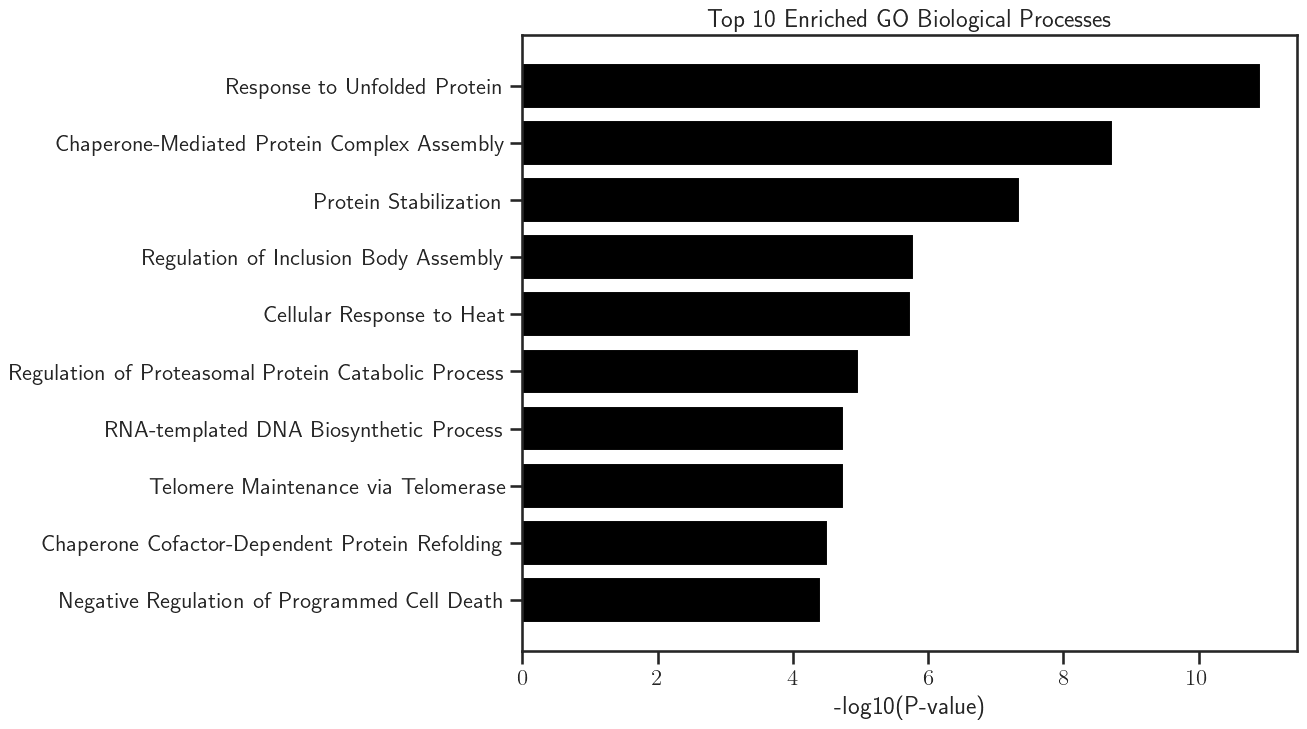

In [16]:
plot_go_enrichment(genes_delete, filename='delete_go')

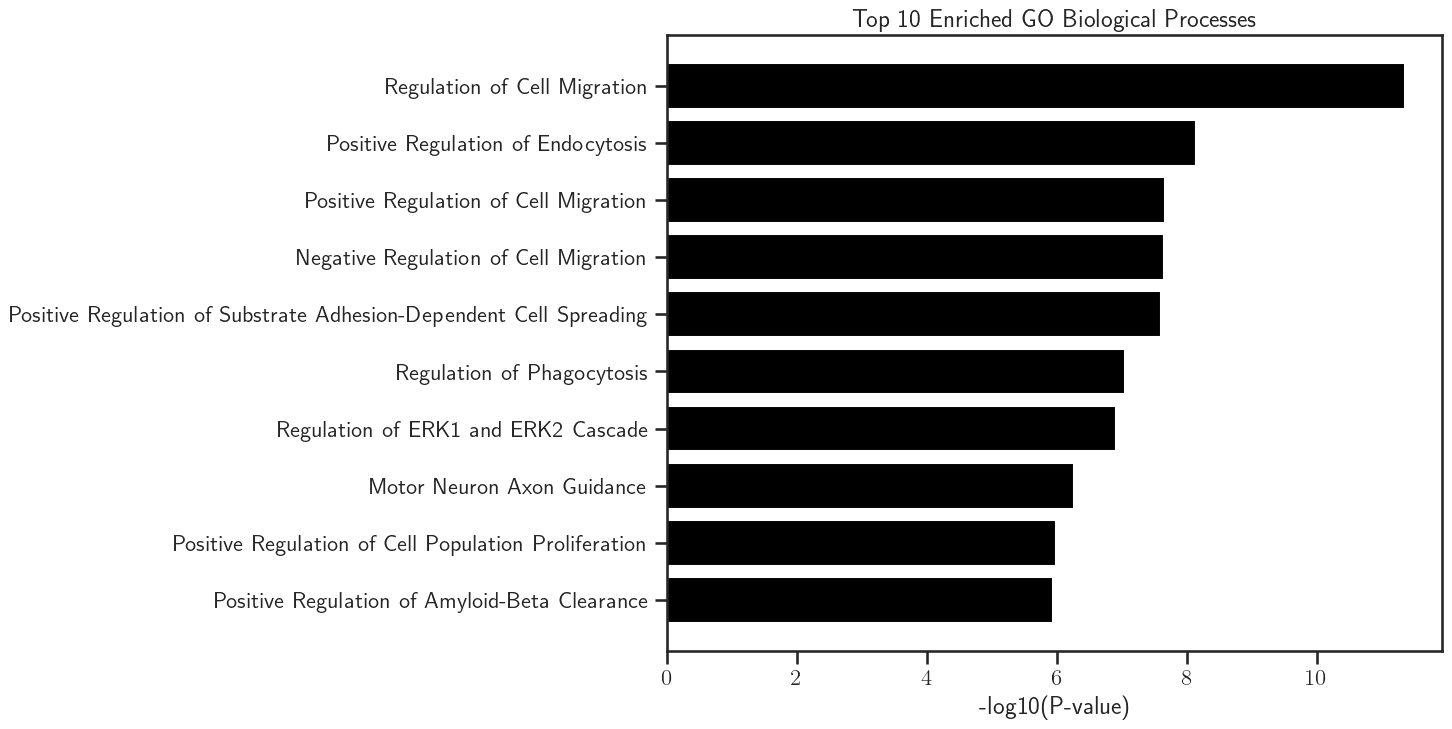

In [17]:
plot_go_enrichment(genes_overexpress, filename = 'overexpress_go')